In [1]:
!pip install kubernetes

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.2 MB/s eta 0:00:00


In [5]:
from kubernetes import client, config
config.load_kube_config() 
v1 = client.CoreV1Api()
#v1.list_node()

In [69]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import networkx as nx
import raphtory as rp
import datetime
#Load collected data from istio into a dataframe. In this file there are logs about gRPC calls between 11 microservices from the app online-boutique
#the ms loadgenerator simu
data=pd.read_csv('st1.log',delimiter=' ')
#select features for graphs
data = data[['START_TIME','QUERY','URL','PROTOCOL','RESPONSE_CODE', 'RESPONSE_FLAGS', 'RESPONSE_CODE_DETAILS',"CONNECTION_TERMINATION_DETAILS","UPSTREAM_TRANSPORT_FAILURE_REASON",'BYTES_RECEIVED','BYTES_SENT', 'DURATION' ,"SERVICE-TIME","FORWARDED-FOR","USER-AGENT","REQUEST-ID","AUTHORITY",'UPSTREAM_HOST',"UPSTREAM_CLUSTER","UPSTREAM_LOCAL_ADDRESS","DOWNSTREAM_LOCAL_ADDRESS",'DOWNSTREAM_REMOTE_ADDRESS',"REQUESTED_SERVER_NAME","ROUTE"]]
pd.options.display.max_rows = None
data.describe()



,RESPONSE_CODE,BYTES_RECEIVED,BYTES_SENT,DURATION,SERVICE-TIME
count,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000
mean,202.946078,24.567688,1621.106390,12.653403,11.957506
std,17.083644,31.990608,4108.040491,22.303301,22.083923
min,200.000000,0.000000,0.000000,0.000000,0.000000
25%,200.000000,17.000000,21.000000,2.000000,2.000000
50%,200.000000,17.000000,148.000000,3.000000,3.000000
75%,200.000000,25.000000,170.000000,6.000000,5.000000
max,302.000000,472.000000,26086.000000,139.000000,137.000000


In [70]:
#data=data.head(1000000) 

In [71]:
#select features for graphs
data = data[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'PROTOCOL','QUERY','BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
pd.options.display.max_rows = None
data.describe()

,RESPONSE_CODE,BYTES_RECEIVED,BYTES_SENT,DURATION
count,9625.000000,9625.000000,9625.000000,9625.000000
mean,202.946078,24.567688,1621.106390,12.653403
std,17.083644,31.990608,4108.040491,22.303301
min,200.000000,0.000000,0.000000,0.000000
25%,200.000000,17.000000,21.000000,2.000000
50%,200.000000,17.000000,148.000000,3.000000
75%,200.000000,25.000000,170.000000,6.000000
max,302.000000,472.000000,26086.000000,139.000000


In [72]:
#All possible QUERY 
QUERY = data['QUERY']
for value in QUERY.unique():
    print(value)

GET
POST


In [73]:
data = data[data['QUERY'].isin(['GET','POST'])]


In [74]:
#All possible response code services (0, 302, and 500 are errors)
RESPONSE_CODE = data['RESPONSE_CODE']
for value in RESPONSE_CODE.unique():
    print(value)

200
302


In [75]:
#All possible upsteram services (destination MS)
UPSTREAM_HOST = data['UPSTREAM_HOST']
for value in UPSTREAM_HOST.unique():
    print(value)

172.17.3.118:8080
172.17.3.89:7000
172.17.3.80:7070
172.17.3.115:8080
172.17.3.125:3550
172.17.3.104:9555
172.17.3.124:50051
172.17.3.102:50051
172.17.3.70:8080
172.17.3.123:5050


In [76]:
'''
adservice-78bb57dfbd-4jl9g 172.17.3.104
cartservice-5b68c68477-2ljsd 172.17.3.80
checkoutservice-854f5747fd-wpkmw 172.17.3.123
currencyservice-7d8f79889b-ljz2z 172.17.3.89
emailservice-6787c86dcd-mbnhm 172.17.3.70
frontend-6659c9d65f-fw5mz 172.17.3.118
loadgenerator-6d7d95df5c-r8vd2 172.17.3.116
paymentservice-7fb78c9cdb-hp7ll 172.17.3.102
productcatalogservice-589d6845fd-wprz2 172.17.3.125
recommendationservice-6cf78cdb66-gk26v 172.17.3.115
redis-cart-bf5c68f69-95gwg 172.17.3.86
shippingservice-584657c6cb-88gdf 172.17.3.124



'''

'\nadservice-78bb57dfbd-4jl9g 172.17.3.104\ncartservice-5b68c68477-2ljsd 172.17.3.80\ncheckoutservice-854f5747fd-wpkmw 172.17.3.123\ncurrencyservice-7d8f79889b-ljz2z 172.17.3.89\nemailservice-6787c86dcd-mbnhm 172.17.3.70\nfrontend-6659c9d65f-fw5mz 172.17.3.118\nloadgenerator-6d7d95df5c-r8vd2 172.17.3.116\npaymentservice-7fb78c9cdb-hp7ll 172.17.3.102\nproductcatalogservice-589d6845fd-wprz2 172.17.3.125\nrecommendationservice-6cf78cdb66-gk26v 172.17.3.115\nredis-cart-bf5c68f69-95gwg 172.17.3.86\nshippingservice-584657c6cb-88gdf 172.17.3.124\n\n\n\n'

In [77]:
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.104','adservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.80','cartservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.123','checkoutservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.89','currencyservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.70','emailservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.118','frontend-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.116','loadgenerator-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.102','paymentservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.125','productcatalogservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.115','recommendationservice-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.86','redis-cart-MS')
data['UPSTREAM_HOST'] = data['UPSTREAM_HOST'].str.replace('172.17.3.124','shippingservice-MS')


In [78]:
#All possible downstream services (Source MS)-  we need to clean that and delete ports to have only MS names 
DOWNSTREAM_REMOTE_ADDRESS = data['DOWNSTREAM_REMOTE_ADDRESS']
for value in DOWNSTREAM_REMOTE_ADDRESS.unique():
    print(value)


172.17.3.116:55508
172.17.3.116:55518
172.17.3.116:58720
172.17.3.116:55482
172.17.3.116:55474
172.17.3.116:58712
172.17.3.116:55532
172.17.3.116:58726
172.17.3.116:55498
172.17.3.116:55522
172.17.3.118:45966
172.17.3.118:33794
172.17.3.118:32912
172.17.3.118:51870
172.17.3.118:53114
172.17.3.116:50022
172.17.3.116:46302
172.17.3.118:56234
172.17.3.116:39504
172.17.3.123:42236
172.17.3.123:45508
172.17.3.123:57274
172.17.3.123:47074
172.17.3.123:33162
172.17.3.123:44590
172.17.3.118:54058
172.17.3.118:57796
172.17.3.116:50020


In [79]:
#change IP by  names
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.104','adservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.80','cartservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.123','checkoutservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.89','currencyservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.70','emailservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.118','frontend-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.116','loadgenerator-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.102','paymentservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.125','productcatalogservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.115','recommendationservice-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.86','redis-cart-MS')
data['DOWNSTREAM_REMOTE_ADDRESS'] = data['DOWNSTREAM_REMOTE_ADDRESS'].str.replace('172.17.3.124','shippingservice-MS')

In [80]:
#Skip this, it was done to take part of the data where there is no calls
'''
#We take out part of the date where there not sercice calls 
data2=data.tail(-60000)
#data3 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
data2.head()
data2.to_csv('out.csv', index=False)  '''

"\n#We take out part of the date where there not sercice calls \ndata2=data.tail(-60000)\n#data3 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]\ndata2.head()\ndata2.to_csv('out.csv', index=False)  "

In [81]:
data.head(20)

,START_TIME,PROTOCOL,RESPONSE_CODE,BYTES_RECEIVED,PROTOCOL,QUERY,BYTES_SENT,DURATION,UPSTREAM_HOST,DOWNSTREAM_REMOTE_ADDRESS
0,[2024-11-27T19:31:16.528Z],HTTP/1.1,200,0,HTTP/1.1,GET,17857,72,frontend-MS:8080,loadgenerator-MS:55508
1,[2024-11-27T19:31:17.059Z],HTTP/1.1,200,0,HTTP/1.1,GET,8043,56,frontend-MS:8080,loadgenerator-MS:55518
2,[2024-11-27T19:31:17.174Z],HTTP/1.1,302,17,HTTP/1.1,POST,0,3,frontend-MS:8080,loadgenerator-MS:58720
3,[2024-11-27T19:31:17.179Z],HTTP/1.1,200,0,HTTP/1.1,GET,10597,62,frontend-MS:8080,loadgenerator-MS:58720
4,[2024-11-27T19:31:17.429Z],HTTP/1.1,200,0,HTTP/1.1,GET,7950,58,frontend-MS:8080,loadgenerator-MS:55482
5,[2024-11-27T19:31:18.513Z],HTTP/1.1,200,0,HTTP/1.1,GET,8038,59,frontend-MS:8080,loadgenerator-MS:55474
6,[2024-11-27T19:31:18.941Z],HTTP/1.1,200,0,HTTP/1.1,GET,24280,99,frontend-MS:8080,loadgenerator-MS:58712
7,[2024-11-27T19:31:20.015Z],HTTP/1.1,200,0,HTTP/1.1,GET,8022,61,frontend-MS:8080,loadgenerator-MS:55532
8,[2024-11-27T19:31:20.078Z],HTTP/1.1,302,32,HTTP/1.1,POST,0,14,frontend-MS:8080,loadgenerator-MS:55532
9,[2024-11-27T19:31:20.093Z],HTTP/1.1,200,0,HTTP/1.1,GET,23214,85,frontend-MS:8080,loadgenerator-MS:55532


In [82]:
#Skip this, it was done to clean the data
#He we correct date time ifformation

#data2=pd.read_csv('out.csv',delimiter=',')#, delimiteurs=';')
#data2 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
for i in range (len(data)):
    #print(data2['START_TIME'][i][1:len(data2['START_TIME'][i])-1])
    date_=data['START_TIME'][i][1:11]
    date_object = datetime.datetime.strptime(date_, '%Y-%m-%d').date()
    #print(date_object,type(date_object))
    time_=data['START_TIME'][i][12:20]
    time_object = datetime.datetime.strptime(time_, '%H:%M:%S').time()
    #print(time_object, type(time_object))
    dt=datetime.datetime.combine(date_object, time_object)
    #data2['START_TIME'][i]=data2['START_TIME'][i][1:len(data2['START_TIME'][i])-1]   
    #datetime_object = datetime.strptime(data2['START_TIME'][i], '%m/%d/%y %H:%M:%S')
    data['START_TIME'][i]=dt
    #print(data2['START_TIME'][i])
    #data2['DOWNSTREAM_LOCAL_ADDRESS'][i]=data2['DOWNSTREAM_LOCAL_ADDRESS'][i][:len(data2['DOWNSTREAM_LOCAL_ADDRESS'][i])-3]
    #data2['DOWNSTREAM_REMOTE_ADDRESS'][i]=data2['DOWNSTREAM_REMOTE_ADDRESS'][i][:len(data2['DOWNSTREAM_REMOTE_ADDRESS'][i])-6]
data.head()


/tmp/ipykernel_214772/4163661406.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['START_TIME'][i]=dt
/tmp/ipykernel_214772/4163661406.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [83]:
#Save this clean data
data.to_csv('out100.csv', index=False)  

In [84]:
'''#Skip this, it was done to clean the data

#data2=pd.read_csv('out.csv',delimiter=',')#, delimiteurs=';')
#data2 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
for i in range (len(data)):
    #print(data2['START_TIME'][i][1:len(data2['START_TIME'][i])-1])
    date_=data['START_TIME'][i][1:11]
    date_object = datetime.datetime.strptime(date_, '%Y-%m-%d').date()
    #print(date_object,type(date_object))
    time_=data['START_TIME'][i][12:20]
    time_object = datetime.datetime.strptime(time_, '%H:%M:%S').time()
    #print(time_object, type(time_object))
    dt=datetime.datetime.combine(date_object, time_object)
    #data2['START_TIME'][i]=data2['START_TIME'][i][1:len(data2['START_TIME'][i])-1]   
    #datetime_object = datetime.strptime(data2['START_TIME'][i], '%m/%d/%y %H:%M:%S')
    data['START_TIME'][i]=dt
    #print(data2['START_TIME'][i])
    #data2['DOWNSTREAM_LOCAL_ADDRESS'][i]=data2['DOWNSTREAM_LOCAL_ADDRESS'][i][:len(data2['DOWNSTREAM_LOCAL_ADDRESS'][i])-3]
    #data2['DOWNSTREAM_REMOTE_ADDRESS'][i]=data2['DOWNSTREAM_REMOTE_ADDRESS'][i][:len(data2['DOWNSTREAM_REMOTE_ADDRESS'][i])-6]
data.head()'''

"#Skip this, it was done to clean the data\n\n#data2=pd.read_csv('out.csv',delimiter=',')#, delimiteurs=';')\n#data2 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]\nfor i in range (len(data)):\n    #print(data2['START_TIME'][i][1:len(data2['START_TIME'][i])-1])\n    date_=data['START_TIME'][i][1:11]\n    date_object = datetime.datetime.strptime(date_, '%Y-%m-%d').date()\n    #print(date_object,type(date_object))\n    time_=data['START_TIME'][i][12:20]\n    time_object = datetime.datetime.strptime(time_, '%H:%M:%S').time()\n    #print(time_object, type(time_object))\n    dt=datetime.datetime.combine(date_object, time_object)\n    #data2['START_TIME'][i]=data2['START_TIME'][i][1:len(data2['START_TIME'][i])-1]   \n    #datetime_object = datetime.strptime(data2['START_TIME'][i], '%m/%d/%y %H:%M:%S')\n    data['START_TIME'][i]=dt\n    #print(data2['START_TIME'][i])\n    #data2['DOWNSTREAM_LOCAL_ADDR

In [85]:
#Skip this, it was done to clean the data
#Here we need to have MS names without port
for i in range (len(data)):
    pos=data['UPSTREAM_HOST'][i].rfind(':')
    data['UPSTREAM_HOST'][i]=data['UPSTREAM_HOST'][i][0:pos]
    pos2=str(data['DOWNSTREAM_REMOTE_ADDRESS'][i]).rfind(':')
    data['DOWNSTREAM_REMOTE_ADDRESS'][i]=str(data['DOWNSTREAM_REMOTE_ADDRESS'][i])[0:pos2]    
data.head()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,START_TIME,PROTOCOL,RESPONSE_CODE,BYTES_RECEIVED,PROTOCOL,QUERY,BYTES_SENT,DURATION,UPSTREAM_HOST,DOWNSTREAM_REMOTE_ADDRESS
0,2024-11-27 19:31:16,HTTP/1.1,200,0,HTTP/1.1,GET,17857,72,frontend-MS,loadgenerator-MS
1,2024-11-27 19:31:17,HTTP/1.1,200,0,HTTP/1.1,GET,8043,56,frontend-MS,loadgenerator-MS
2,2024-11-27 19:31:17,HTTP/1.1,302,17,HTTP/1.1,POST,0,3,frontend-MS,loadgenerator-MS
3,2024-11-27 19:31:17,HTTP/1.1,200,0,HTTP/1.1,GET,10597,62,frontend-MS,loadgenerator-MS
4,2024-11-27 19:31:17,HTTP/1.1,200,0,HTTP/1.1,GET,7950,58,frontend-MS,loadgenerator-MS


In [86]:
'''#Skip this, it was done to clean the datafor i in range (len(data2)):
    pos=data['UPSTREAM_HOST'][i].rfind(':')
    data['UPSTREAM_HOST'][i]=data['UPSTREAM_HOST'][i][0:pos]
    pos2=str(data['DOWNSTREAM_REMOTE_ADDRESS'][i]).rfind(':')
    data['DOWNSTREAM_REMOTE_ADDRESS'][i]=str(data['DOWNSTREAM_REMOTE_ADDRESS'][i])[0:pos2]    
data.head()'''

"#Skip this, it was done to clean the datafor i in range (len(data2)):\n    pos=data['UPSTREAM_HOST'][i].rfind(':')\n    data['UPSTREAM_HOST'][i]=data['UPSTREAM_HOST'][i][0:pos]\n    pos2=str(data['DOWNSTREAM_REMOTE_ADDRESS'][i]).rfind(':')\n    data['DOWNSTREAM_REMOTE_ADDRESS'][i]=str(data['DOWNSTREAM_REMOTE_ADDRESS'][i])[0:pos2]    \ndata.head()"

In [87]:
#Skip this, it was done to clean the data 
#Sort the data by timestamp and save another version
data=data.sort_values(by='START_TIME')  
data.to_csv('cleaned3.csv', index=False) 




In [25]:
# let's open the data ordered in timeseries and ready for graphs now if we need that
'''data=pd.read_csv('cleaned3.csv',delimiter=',')#, delimiteurs=';')'''
data.head(10)

,START_TIME,PROTOCOL,RESPONSE_CODE,BYTES_RECEIVED,PROTOCOL.1,QUERY,BYTES_SENT,DURATION,UPSTREAM_HOST,DOWNSTREAM_REMOTE_ADDRESS
0,2024-11-27 15:28:45,HTTP/1.1,500,0,HTTP/1.1,GET,5002,2584,frontend-MS,loadgenerator-MS
1,2024-11-27 15:28:45,HTTP/1.1,500,0,HTTP/1.1,GET,5001,2588,frontend-MS,loadgenerator-MS
2,2024-11-27 15:28:45,HTTP/1.1,500,0,HTTP/1.1,GET,5002,2597,frontend-MS,loadgenerator-MS
3,2024-11-27 15:28:46,HTTP/1.1,500,0,HTTP/1.1,GET,5001,1609,frontend-MS,loadgenerator-MS
4,2024-11-27 15:28:46,HTTP/1.1,500,0,HTTP/1.1,GET,5001,2140,frontend-MS,loadgenerator-MS
5,2024-11-27 15:28:46,HTTP/1.1,302,32,HTTP/1.1,POST,0,1595,frontend-MS,loadgenerator-MS
6,2024-11-27 15:28:46,HTTP/1.1,500,0,HTTP/1.1,GET,5002,1827,frontend-MS,loadgenerator-MS
7,2024-11-27 15:28:46,HTTP/1.1,500,0,HTTP/1.1,GET,5001,1968,frontend-MS,loadgenerator-MS
8,2024-11-27 15:28:46,HTTP/1.1,500,0,HTTP/1.1,GET,4997,2495,frontend-MS,loadgenerator-MS
9,2024-11-27 15:28:46,HTTP/1.1,500,0,HTTP/1.1,GET,5001,1901,frontend-MS,loadgenerator-MS


In [105]:
#Here we divide the data into 11 files of size 5000 lines ordered in time so we can construct a Temporal graph for each file and see the dynamic call evolution

'''data = data[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
pd.options.display.max_rows = None
for i in range (int(len(data)/5000)):
    datay=data.head(5000)
    data=data.tail(-5000)
    name='file'+str(i)+'.csv'
    print(name)
    datay.to_csv(name, index=False) '''
    

file0.csv
file1.csv
file2.csv
file3.csv
file4.csv
file5.csv
file6.csv
file7.csv
file8.csv
file9.csv
file10.csv


Graph(number_of_nodes=4, number_of_edges=3, number_of_temporal_edges=5000, earliest_time=61616000000, latest_time=63061000000)


Graph(number_of_nodes=5, number_of_edges=4, number_of_temporal_edges=5000, earliest_time=63061000000, latest_time=63266000000)


Graph(number_of_nodes=5, number_of_edges=4, number_of_temporal_edges=5000, earliest_time=63266000000, latest_time=63503000000)


Graph(number_of_nodes=6, number_of_edges=5, number_of_temporal_edges=5000, earliest_time=63503000000, latest_time=63929000000)


Graph(number_of_nodes=7, number_of_edges=7, number_of_temporal_edges=5000, earliest_time=63929000000, latest_time=64176000000)


Graph(number_of_nodes=3, number_of_edges=2, number_of_temporal_edges=5000, earliest_time=64176000000, latest_time=64220000000)


Graph(number_of_nodes=3, number_of_edges=2, number_of_temporal_edges=5000, earliest_time=64220000000, latest_time=64264000000)


Graph(number_of_nodes=7, number_of_edges=7, number_of_temporal_edges=5000, earliest_time=64264000000, latest_time=64293000000)


Graph(number_of_nodes=9, number_of_edges=8, number_of_temporal_edges=5000, earliest_time=64293000000, latest_time=64303000000)


Graph(number_of_nodes=9, number_of_edges=9, number_of_temporal_edges=5000, earliest_time=64303000000, latest_time=64307000000)


Graph(number_of_nodes=11, number_of_edges=12, number_of_temporal_edges=5000, earliest_time=64307000000, latest_time=64312000000)


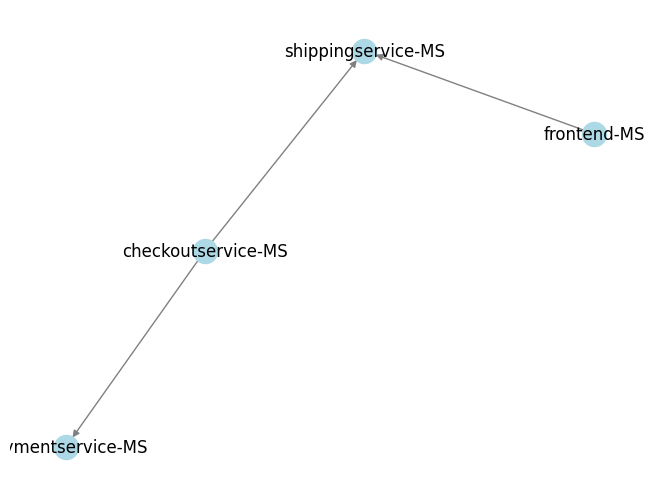

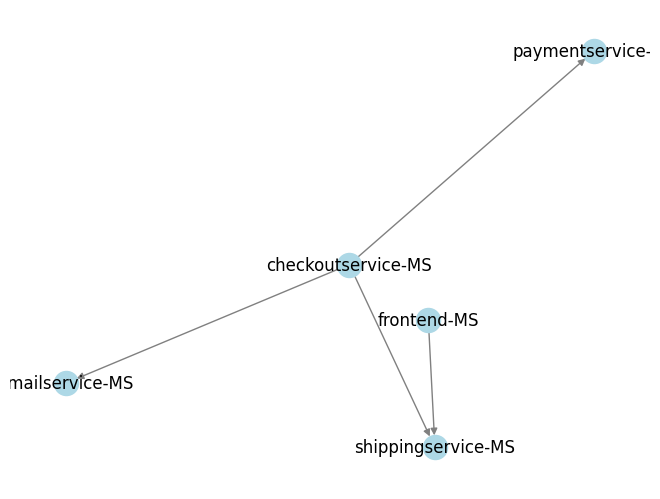

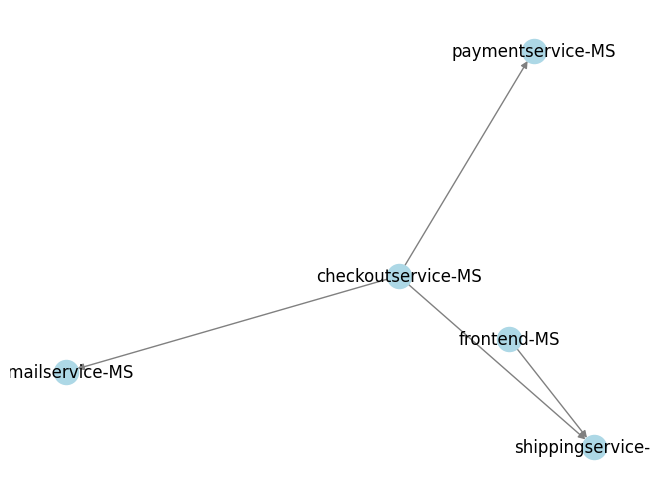

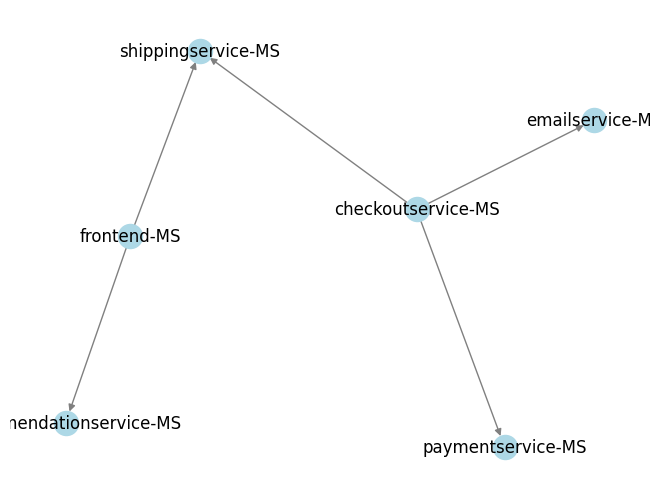

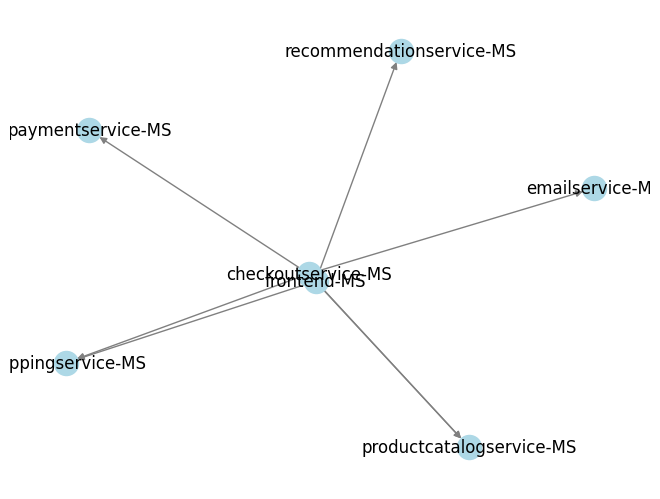

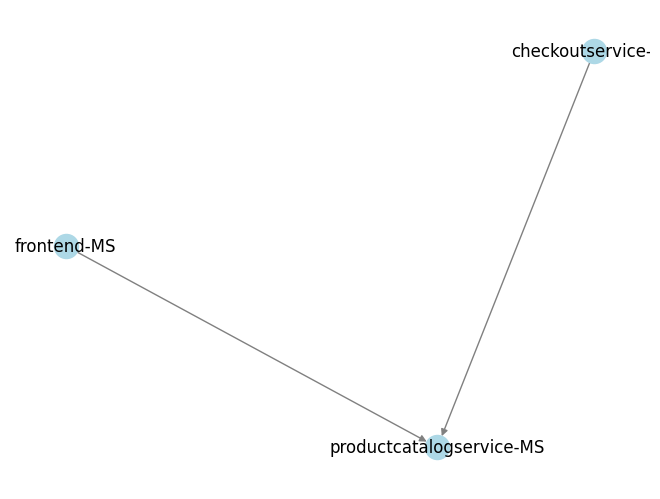

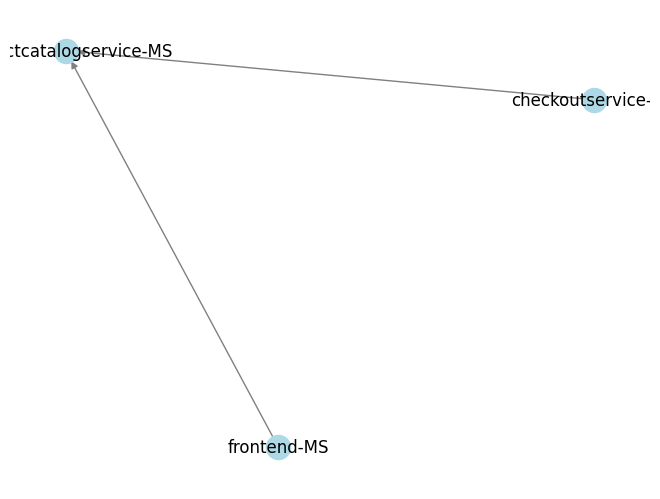

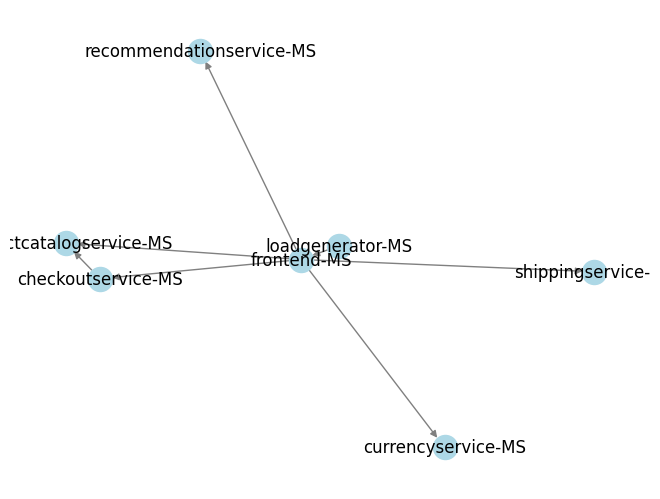

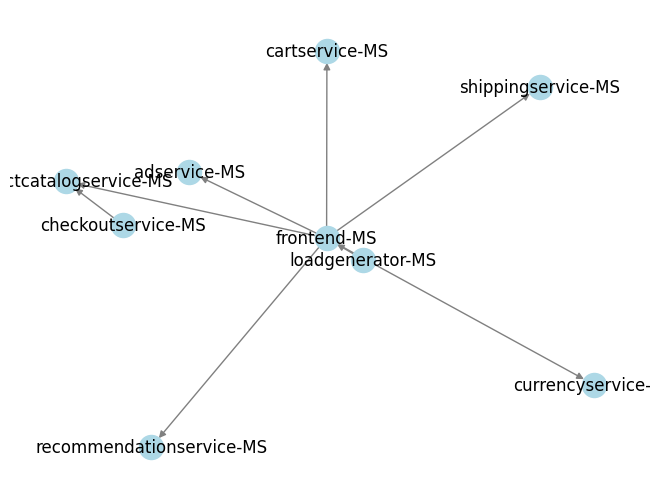

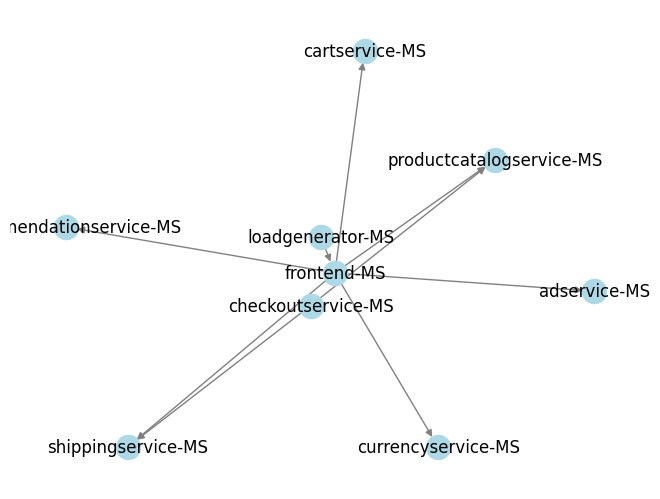

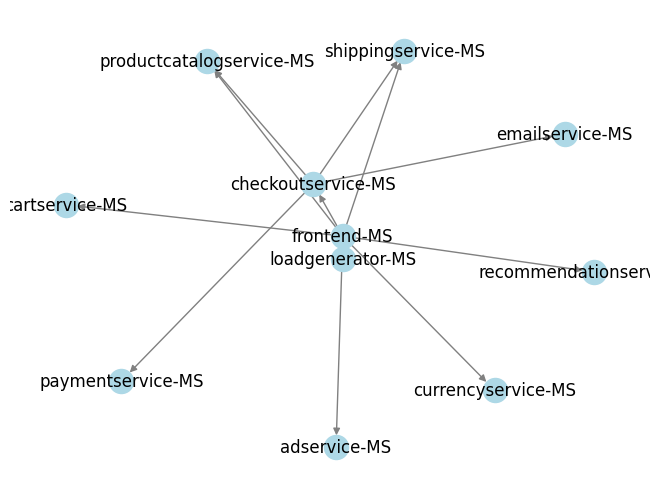

In [106]:
#Letś print graphs from the files 

'''for j in range (11):
    name='file'+str(j)+'.csv'
    data2=pd.read_csv(name,delimiter=',')#, delimiteurs=';')
    data2 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
    data2['START_TIME'] = pd.to_datetime(data2['START_TIME']).dt.time
    #data2=data2.sort_values(by='START_TIME')  
    g = rp.Graph()
    g.load_edges_from_pandas(
    df=data2,
    time="START_TIME",
    src="DOWNSTREAM_REMOTE_ADDRESS",
    dst="UPSTREAM_HOST",
    properties=["RESPONSE_CODE","BYTES_RECEIVED" ,"BYTES_SENT", "DURATION"],
    )
    print(g)
    nx_g = g.to_networkx()
    plt.figure(j)
    nx.draw(nx_g, with_labels=True, node_color="lightblue", edge_color="gray")

    
plt.show()'''


Graph(number_of_nodes=11, number_of_edges=14, number_of_temporal_edges=9612, earliest_time=1732735876000, latest_time=1732736222000)


,START_TIME,PROTOCOL,RESPONSE_CODE,BYTES_RECEIVED,PROTOCOL,QUERY,BYTES_SENT,DURATION,UPSTREAM_HOST,DOWNSTREAM_REMOTE_ADDRESS
0,2024-11-27 19:31:16,HTTP/1.1,200,0,HTTP/1.1,GET,17857,72,frontend-MS,loadgenerator-MS
1,2024-11-27 19:31:17,HTTP/1.1,200,0,HTTP/1.1,GET,8043,56,frontend-MS,loadgenerator-MS
2,2024-11-27 19:31:17,HTTP/1.1,302,17,HTTP/1.1,POST,0,3,frontend-MS,loadgenerator-MS
3,2024-11-27 19:31:17,HTTP/1.1,200,0,HTTP/1.1,GET,10597,62,frontend-MS,loadgenerator-MS
4,2024-11-27 19:31:17,HTTP/1.1,200,0,HTTP/1.1,GET,7950,58,frontend-MS,loadgenerator-MS


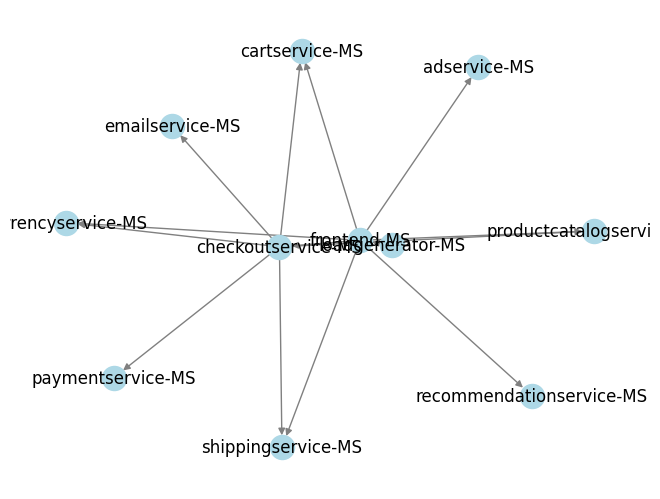

In [88]:
#Here we try to use windows in raphtory to construct these graphs by a window (a window is defined by a start date and an end date)
#HHere we will build one graph from the beginning to the end of time of monitoring (one window)

'''data2=pd.read_csv('cleaned.csv',delimiter=',')#, delimiteurs=';')
data2 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
data2['START_TIME'] = pd.to_datetime(data2['START_TIME'])'''


g_all = rp.Graph()
g_all.load_edges_from_pandas(
df=data,
time="START_TIME",
src="DOWNSTREAM_REMOTE_ADDRESS",
dst="UPSTREAM_HOST",
properties=["RESPONSE_CODE","BYTES_RECEIVED" ,"BYTES_SENT", "DURATION"],
)
start_date = datetime.datetime.strptime("2024-11-27 19:31:16", "%Y-%m-%d %H:%M:%S")
end_date = datetime.datetime.strptime("2024-11-27 19:37:03", "%Y-%m-%d %H:%M:%S")


e = g_all.window(start_date,end_date)
print(e)
nx_g = e.to_networkx()
nx.draw(nx_g, with_labels=True, node_color="lightblue", edge_color="gray")
data.head()


In [89]:
# Here more windows
# Number of needed windows
# Here we will contrsct temporal graphs by window size we define
# initializing date
start_date = datetime.datetime.strptime("2024-11-27 19:31:16", "%Y-%m-%d %H:%M:%S")
end_date = datetime.datetime.strptime("2024-11-27 19:37:03", "%Y-%m-%d %H:%M:%S")

minutes_diff = (end_date - start_date).total_seconds() / 60.0
window_mimutes_size=1 # means 1 minute
number_of_windows = int(minutes_diff//window_mimutes_size)
print(number_of_windows)

# initializing dates
date_generated = pd.date_range(start_date, end_date, periods=number_of_windows+1)
print(type(date_generated))
print(date_generated.strftime("%Y-%m-%d %H:%M:%S"))

5
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index(['2024-11-27 19:31:16', '2024-11-27 19:32:25', '2024-11-27 19:33:34',
       '2024-11-27 19:34:44', '2024-11-27 19:35:53', '2024-11-27 19:37:03'],
      dtype='object')


2024-11-27 19:31:16 2024-11-27 19:32:25.400000
Graph(number_of_nodes=8, number_of_edges=7, number_of_temporal_edges=538, earliest_time=1732735876000, latest_time=1732735945000)
2024-11-27 19:32:25.400000 2024-11-27 19:33:34.800000
Graph(number_of_nodes=11, number_of_edges=14, number_of_temporal_edges=2259, earliest_time=1732735946000, latest_time=1732736013000)
2024-11-27 19:33:34.800000 2024-11-27 19:34:44.200000
Graph(number_of_nodes=11, number_of_edges=14, number_of_temporal_edges=2104, earliest_time=1732736015000, latest_time=1732736084000)
2024-11-27 19:34:44.200000 2024-11-27 19:35:53.600000
Graph(number_of_nodes=11, number_of_edges=14, number_of_temporal_edges=2352, earliest_time=1732736085000, latest_time=1732736152000)
2024-11-27 19:35:53.600000 2024-11-27 19:37:03
Graph(number_of_nodes=11, number_of_edges=14, number_of_temporal_edges=2359, earliest_time=1732736155000, latest_time=1732736222000)


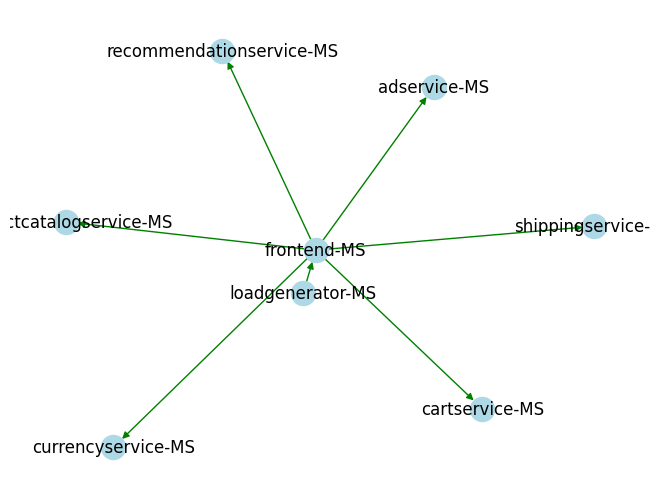

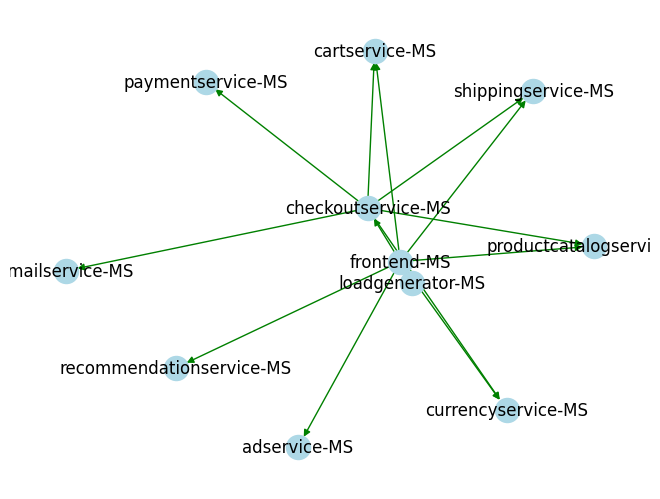

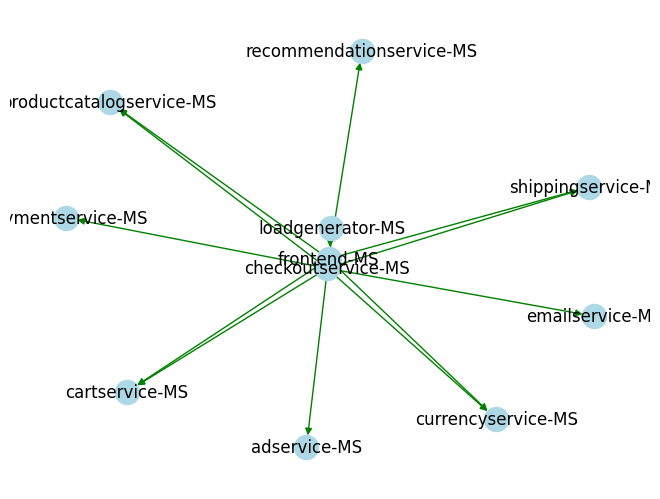

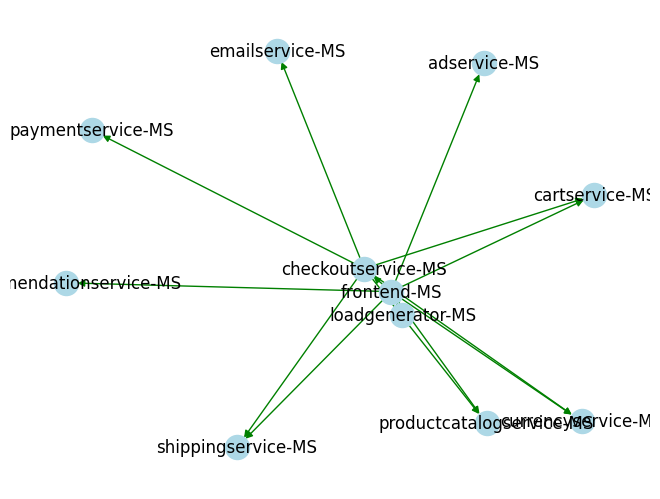

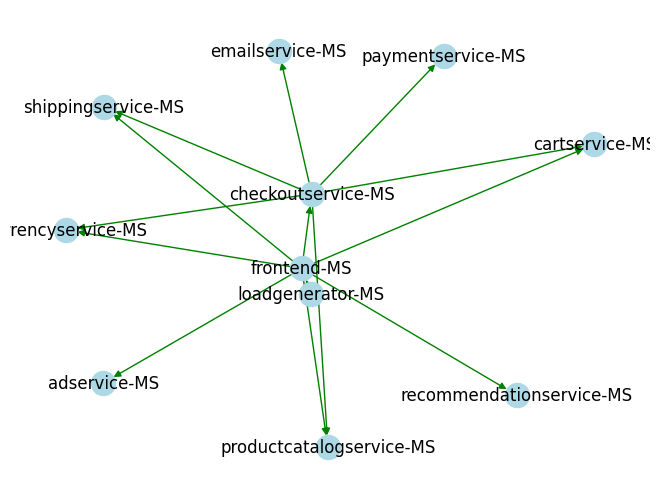

In [92]:
''''#Here we try to use windows in raphtory to construct healthy graphs in windows (response code = 200)
data2=pd.read_csv('cleaned.csv',delimiter=',')#, delimiteurs=';')
data2 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
data2['START_TIME'] = pd.to_datetime(data2['START_TIME'])
healthy_df = data2[data2['RESPONSE_CODE'] == 200]
'''
g_tkg = rp.Graph()
g_tkg.load_edges_from_pandas(
df=data,
time="START_TIME",
src="DOWNSTREAM_REMOTE_ADDRESS",
dst="UPSTREAM_HOST",
properties=["RESPONSE_CODE","BYTES_RECEIVED" ,"BYTES_SENT", "DURATION"],
)

for i in range(number_of_windows):
    start_date=date_generated[i]
    end_date=date_generated[i+1]
    print(start_date,end_date)
    e = g_tkg.window(start_date,end_date)
    print(e)
    nx_g = e.to_networkx()
    plt.figure(i)
    nx.draw(nx_g, with_labels=True, node_color="lightblue", edge_color="green")

plt.show()

2024-11-13 17:40:00 2024-11-13 17:41:05
Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)
2024-11-13 17:41:05 2024-11-13 17:42:10
Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)
2024-11-13 17:42:10 2024-11-13 17:43:15
Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)
2024-11-13 17:43:15 2024-11-13 17:44:20
Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)
2024-11-13 17:44:20 2024-11-13 17:45:25
Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)
2024-11-13 17:45:25 2024-11-13 17:46:30
Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)
2024-11-13 17:46:30 2024-11-13 17:47:35
Graph(number_of_nodes=0, number_of_edges=0, number_of_tempor

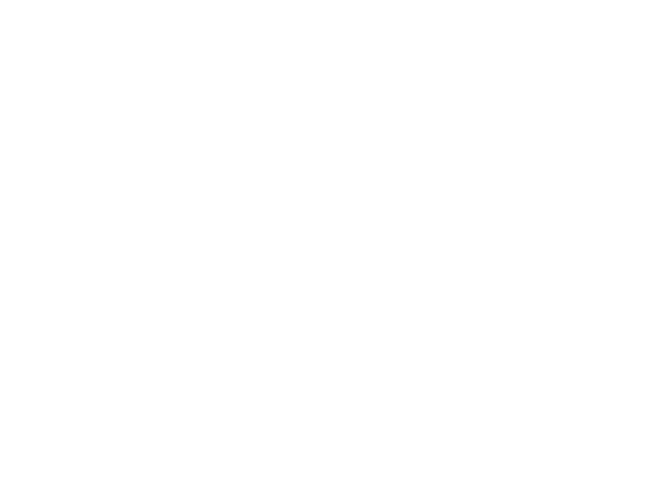

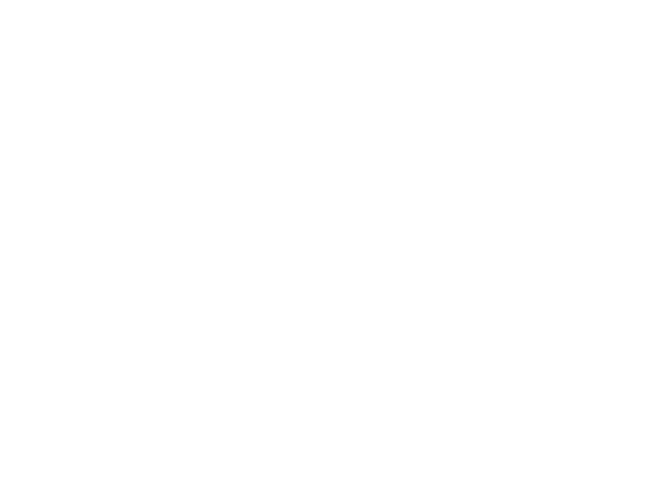

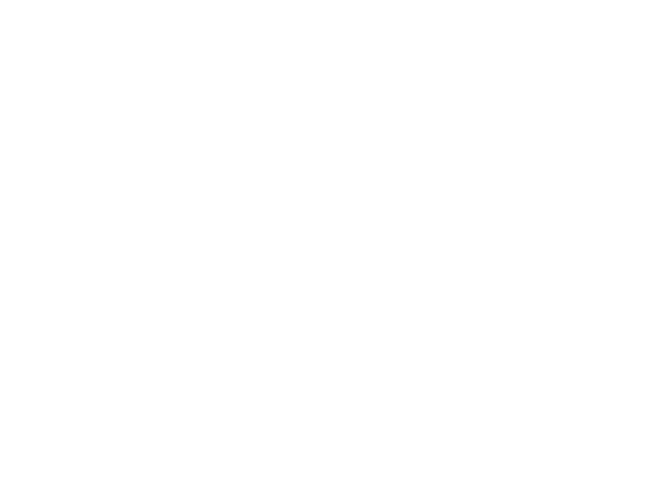

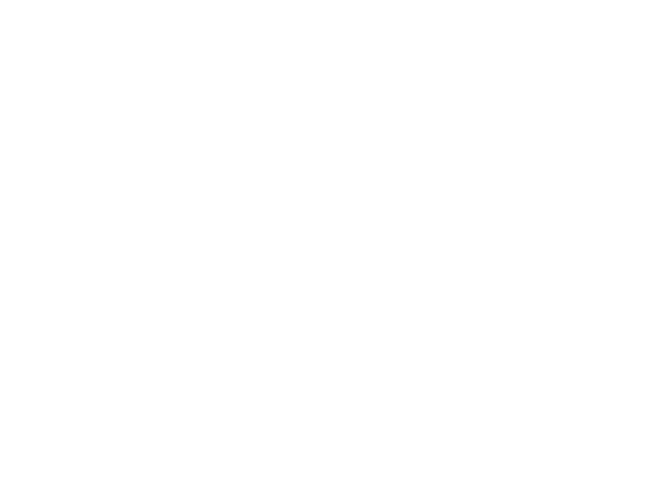

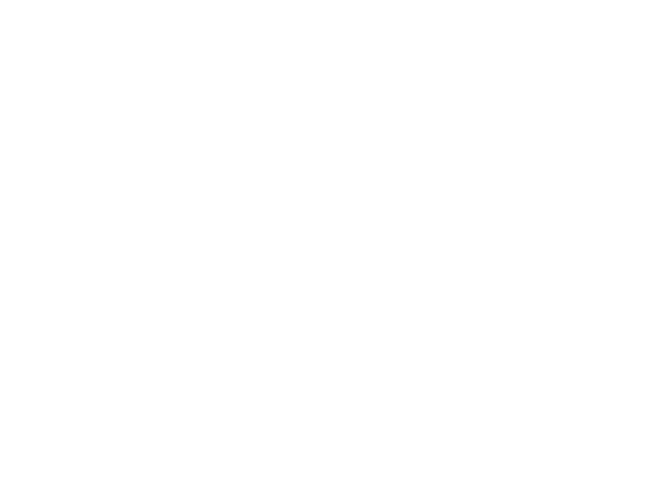

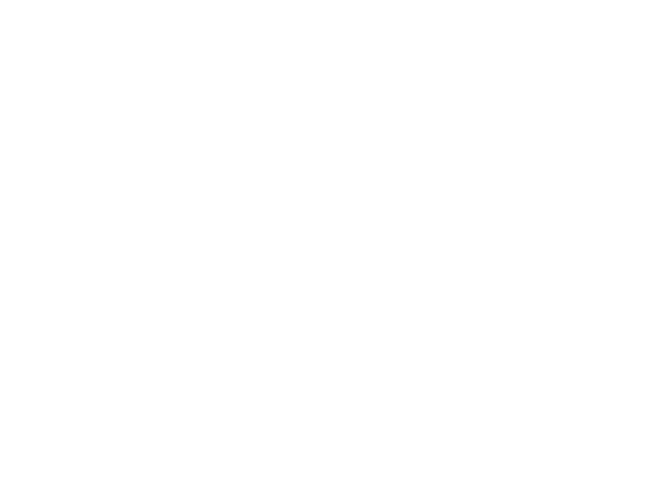

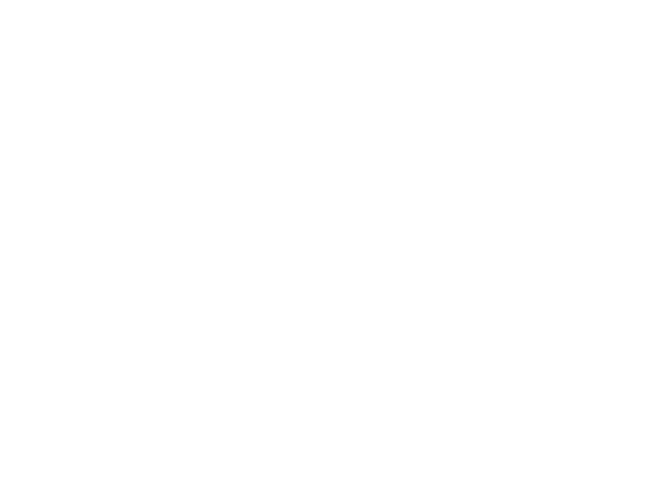

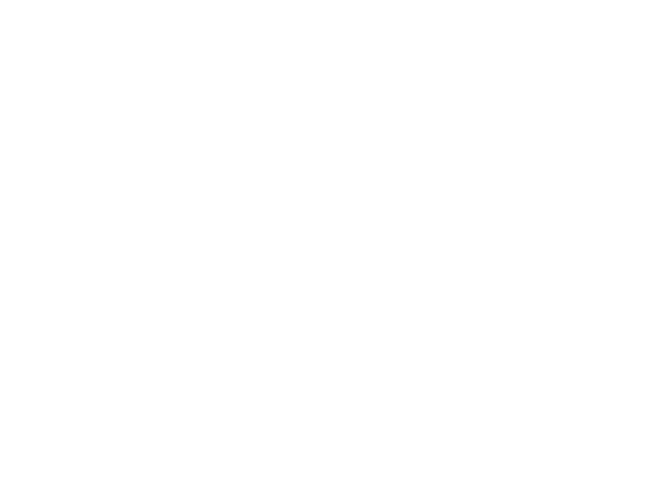

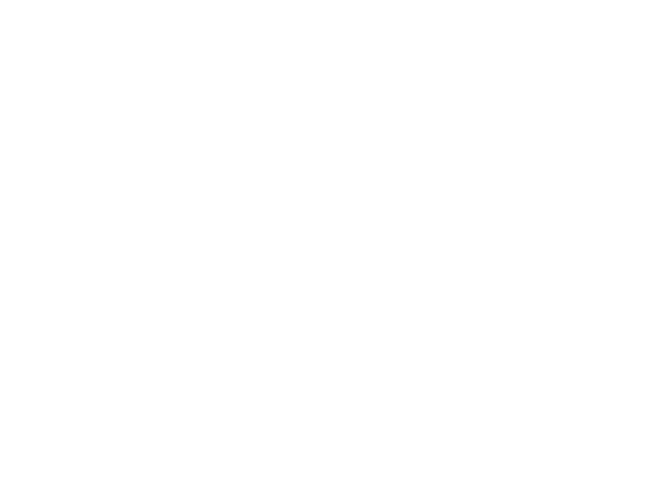

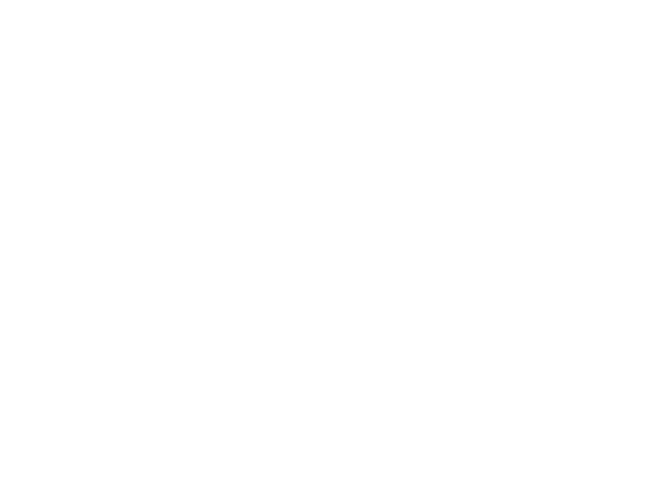

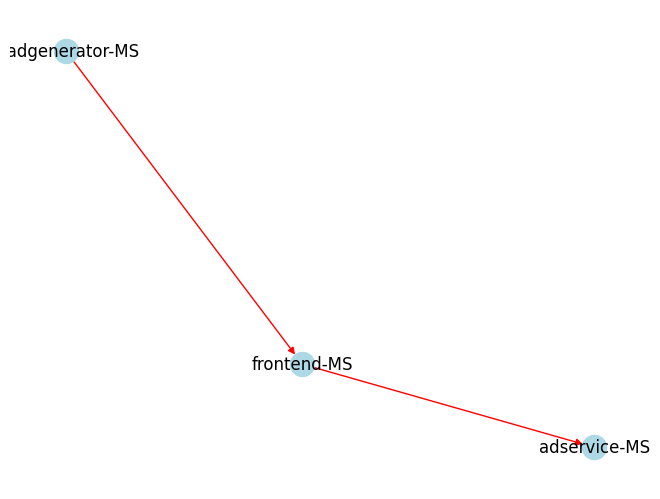

In [110]:
#consider only error graphs
error_df = data2[data2['RESPONSE_CODE'] != 200]
g_errors = rp.Graph()
g_errors.load_edges_from_pandas(
    df=error_df,
    time="START_TIME",
    src="DOWNSTREAM_REMOTE_ADDRESS",
    dst="UPSTREAM_HOST",
    properties=["RESPONSE_CODE","BYTES_RECEIVED" ,"BYTES_SENT", "DURATION"],
)

for i in range(number_of_windows):
    start_date=date_generated[i]
    end_date=date_generated[i+1]
    print(start_date,end_date)
    e = g_errors.window(start_date,end_date)
    print(e)
    nx_g = e.to_networkx()
    plt.figure(i)
    nx.draw(nx_g, with_labels=True, node_color="lightblue", edge_color="red")

plt.show()

In [126]:
#Here we try to use windows in raphtory to construct healthy graphs in windows (response code = 200)
data2=pd.read_csv('cleaned.csv',delimiter=',')#, delimiteurs=';')
data2 = data2[['START_TIME','PROTOCOL','RESPONSE_CODE', 'BYTES_RECEIVED' ,'BYTES_SENT', 'DURATION' ,'UPSTREAM_HOST','DOWNSTREAM_REMOTE_ADDRESS']]
data2['START_TIME'] = pd.to_datetime(data2['START_TIME'])
healthy_df = data2[data2['RESPONSE_CODE'] == 200]
g_ = rp.Graph()
g_.load_edges_from_pandas(
df=healthy_df,
time="START_TIME",
src="DOWNSTREAM_REMOTE_ADDRESS",
dst="UPSTREAM_HOST",
properties=["RESPONSE_CODE","BYTES_RECEIVED" ,"BYTES_SENT", "DURATION"],
)
g_.load_edges_from_pandas(
df=error_df,
time="START_TIME",
src="DOWNSTREAM_REMOTE_ADDRESS",
dst="UPSTREAM_HOST",
properties=["RESPONSE_CODE","BYTES_RECEIVED" ,"BYTES_SENT", "DURATION"],
)

'''L= healthy_df["DOWNSTREAM_REMOTE_ADDRESS","UPSTREAM_HOST"].values.tolist()
for i in range(number_of_windows):
    start_date=date_generated[i]
    end_date=date_generated[i+1]
    print(start_date,end_date)
    e = g_.window(start_date,end_date)
    print(e)
    nx_g = e.to_networkx()
    plt.figure(i)
    nx.draw(nx_g, with_labels=True, node_color="lightblue", edgelist=L, edge_color="green")
plt.show()'''

'L= healthy_df["DOWNSTREAM_REMOTE_ADDRESS","UPSTREAM_HOST"].values.tolist()\nfor i in range(number_of_windows):\n    start_date=date_generated[i]\n    end_date=date_generated[i+1]\n    print(start_date,end_date)\n    e = g_.window(start_date,end_date)\n    print(e)\n    nx_g = e.to_networkx()\n    plt.figure(i)\n    nx.draw(nx_g, with_labels=True, node_color="lightblue", edgelist=L, edge_color="green")\nplt.show()'

In [130]:
print("The resulting graphs and example node/edge:")
print(g)
print("Stats on the graph structure:")
print(g.nodes)
number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()
unique_layers = g.unique_layers
print (number_of_nodes)
print(g.edges)

The resulting graphs and example node/edge:
Graph(number_of_nodes=11, number_of_edges=12, number_of_temporal_edges=5000, earliest_time=64307000000, latest_time=64312000000)
Stats on the graph structure:
Nodes(Node(name=frontend-MS, earliest_time=64307000000, latest_time=64312000000), Node(name=loadgenerator-MS, earliest_time=64307000000, latest_time=64312000000), Node(name=checkoutservice-MS, earliest_time=64309000000, latest_time=64312000000), Node(name=productcatalogservice-MS, earliest_time=64307000000, latest_time=64312000000), Node(name=adservice-MS, earliest_time=64307000000, latest_time=64311000000), Node(name=recommendationservice-MS, earliest_time=64308000000, latest_time=64312000000), Node(name=currencyservice-MS, earliest_time=64307000000, latest_time=64310000000), Node(name=shippingservice-MS, earliest_time=64307000000, latest_time=64312000000), Node(name=cartservice-MS, earliest_time=64307000000, latest_time=64312000000), Node(name=emailservice-MS, earliest_time=6431000000